## Trabajo Final de Text Mining
### Integrantes: Juan Pablo Pilorget, Pablo Santoro y Mauro Veneziano.
### Objetivo: clasificar sentencias según su status de verdad-mentira.
### El dataset fue obtenido de [acá](http://lit.eecs.umich.edu/~deceptiondetection/)

### Importo las librerías

In [5]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import random
import io
import gensim
import struct 
import nltk
import pickle
from empath import Empath
from textstat.textstat import textstat as txt
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import seaborn as sns
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import linear_model

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Cargo el dataset

In [7]:
df = pd.read_csv("7Truth7LiesDataset.csv",sep = ',', quotechar="'",escapechar="\\")
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
df = df.rename(columns={"class":"clase"}) # class es palabra reservada
df['clase'] = np.where(df['clase'] == 'truth', 1, 0)

#### Tomo el texto para el clasificador

In [143]:
trainset_texto, testset_texto, trainset_clase, testset_clase =  train_test_split(df.text,df.clase,stratify=df.clase, test_size=0.3, random_state = 123)

#### Aca armo devset

In [144]:
trainset_texto, devset_texto, trainset_clase, devset_clase =  train_test_split(trainset_texto,trainset_clase,stratify=trainset_clase, test_size=0.2, random_state = 123)

### Construyo los tokenizadores y limpiadores

In [10]:
def clean_text(text):
    text = re.sub('(\[")|("\])'," ",text)
    return text.lower().strip()
# Tokenizador
def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha() and len(w)>1]

#### Este tokenizador deja palabras con largo mayor a 1 (A REVISAR). Hay que evaluar si la autorreferencialidad (I) es imoprtante en inglés.

In [11]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t.isalpha() and len(t)>1]

### Construyo el count vectorizer

In [31]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=LemmaTokenizer(), min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto)
testset_texto_token = count_vect.transform(testset_texto)

In [32]:
corpus = " ".join(trainset_texto)
sent_tokenize(corpus)
# reemplazo numeros con " num " y  paso a minuscula 
reg_num = re.compile(r"\d+[.,]?\d*") # Regular expression to search numbers
corpus = reg_num.sub(" NUM ",corpus).lower()  
corpus = sent_tokenize(corpus)

# tiro los tokens no alphabeticos 
trainset_tokenizado = []
for sent in tqdm(corpus):
    tokens = []
    for token in word_tokenize(sent):
        if token.isalpha():
            tokens.append(token)
    trainset_tokenizado.append(tokens)

100%|██████████| 4077/4077 [00:01<00:00, 3443.45it/s]


In [9]:
corpus[:10]

['my friends hung out without me.',
 'i am always honest butterfly is a plant the kerala film industry is the biggest film industry in india.',
 'i made steaks on the grill with corn on the cob for dinner.',
 'the moon has lower gravity than the earth labs are always yellow playstation is a product developed by sony.',
 'there are many recipe sites on the internet that are based toward people who are not interested in processed foods.',
 'only when there are clouds in the sky, there will be lightening and thunder.',
 'i am fluent in spanish.',
 'i was born in america.',
 'everyone can lose weight with healthy diet and exercise.',
 "since homework is not very important it is ok to copy your friend's instead of doing your work yourself."]

In [10]:
print ("el corpus tiene",len(trainset_texto), "oraciones y",sum([len(word_tokenize(x)) for x in trainset_texto]),"tokens")

el corpus tiene 4013 oraciones y 36804 tokens


### Incorporo el código para Word embeddings

In [11]:
GLOVE_6B_50D_PATH = "../Maestría en Data Mining/glove.6B.50d.txt"
encoding="utf-8"

In [46]:
with open(GLOVE_6B_50D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

FileNotFoundError: [Errno 2] No such file or directory: '../Maestría en Data Mining/glove.6B.50d.txt'

In [17]:
X, y = [], []
for i in range(len(trainset_tokenizado)):
    X.append(trainset_tokenizado[i])
    y.append(trainset_clase.tolist()[i])
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))

total examples 4077


In [18]:
glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

FileNotFoundError: [Errno 2] No such file or directory: '../Maestría en Data Mining/glove.6B.50d.txt'

In [19]:
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

In [142]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

### Construyo un clasificador Naive Bayes

In [33]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()

alpha: 3
fscore_cv= 0.5523782385810833


In [13]:
filename = 'nb_lemmatizado_sololetras.sav'
pickle.dump(grid_search_MNB, open(filename, 'wb'))

### Grafico los F-scores del Naive Bayes

Text(0.5,1,'p-val=0.0')

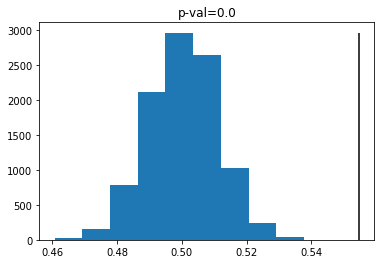

In [14]:
f_measure_random = [f1_score(list(testset_clase), random.sample(list(testset_clase), len(testset_clase)), average="macro") for i in range(10000)]
# Histograma
histograma = plt.hist(f_measure_random)
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>MNB_score).sum()/len(f_measure_random)))

### Construyo un clasificador Random Forest

In [15]:
clf_RF = RandomForestClassifier(class_weight="balanced",random_state=123)
# Parametros a variar 
parameters = {'n_estimators':[1000, 1200],'max_features': [10,20,'auto'],"max_depth":[5,10,None] }
# define un grid search a realizar 
grid_search_RF = GridSearchCV(clf_RF, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_RF.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_RF = grid_search_RF.best_estimator_
print ("n_estimators:",best_clf_RF.n_estimators,"; max_features:",best_clf_RF.max_features,"; max_depth:",best_clf_RF.max_depth )
print("fscore_cv=",grid_search_RF.cv_results_["mean_test_score"].max())

KeyboardInterrupt: 

In [ ]:
filename = 'randomforest_lemmatizado_sololetras.sav'
pickle.dump(grid_search_RF, open(filename, 'wb'))

### Evalúo el desempeño entre Naive Bayes y Random Forest mediante un histograma

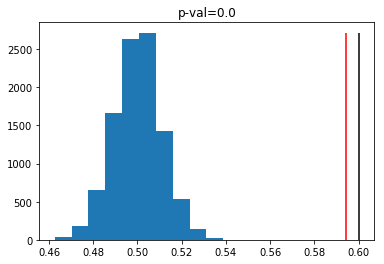

In [160]:
rfscore = grid_search_RF.cv_results_["mean_test_score"].max()
histograma = plt.hist(f_measure_random)
plt.vlines(rfscore,ymin=0,ymax=histograma[0].max()) #En negro Random Forest
plt.title("p-val="+str((f_measure_random>rfscore).sum()/len(f_measure_random)))
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max(),color="red") #En rojo Naive Bayes

### Grafico las palabras importantes

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016]),
 <a list of 9 Text yticklabel objects>)

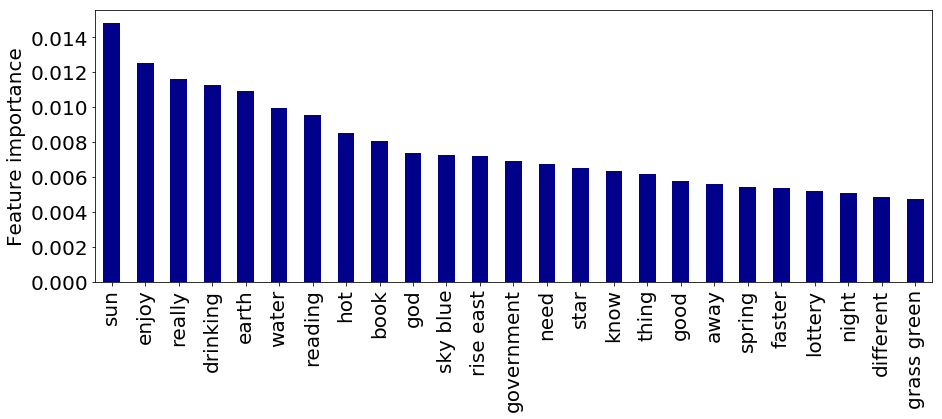

In [139]:
important_words = pd.Series(best_clf_RF.feature_importances_,index=count_vect.get_feature_names()).sort_values(ascending=False)[:25]
important_words.plot(kind="bar",figsize=(15,5),color="darkblue")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)
# Es probable que wa y ha sean problema del tokenizador 

### Armo un Pipeline para evaluar usando TF-IDF

In [58]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer,stop_words="english",ngram_range=(1,2))),
                     ('reduce_dim', SelectKBest(mutual_info_classif)),
                     ('clf',  MultinomialNB())])
    
parameters = {'tfidf__use_idf': [True],
              'tfidf__min_df': [3,5,7,10],
              'clf__alpha': [0.001, 0.01,0.1,1,10,100]}

clf_pipe = GridSearchCV(pipeline, parameters, scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)

clf_pipe.fit(trainset_texto, trainset_clase)

best_pipeline = clf_pipe.best_estimator_

1    891
0    113
dtype: int64

In [59]:
filename = 'nb_tfidf_cleantext.sav'
pickle.dump(clf_pipe, open(filename, 'wb'))

#### Evalúo el Pipeline

In [13]:
print("Best score:",clf_pipe.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline.get_params()
print("use idf:",best_parameters["tfidf__use_idf"])
print("RF max_features:",best_parameters["tfidf__min_df"])
print("RF max_depth:",best_parameters["clf__alpha"])

Best score: 0.4031697131727374

Best parameters set:
use idf: True
RF max_features: 10
RF max_depth: 10


In [ ]:
#### ACÁ EMPIEZO OTRA PARTE

In [4]:
## VOY A ARMAR UN MODELO PARA COMPLEJIDAD DE LA EXPRESION

In [ ]:
## Empiezo con cosas basicas como algunos signos de puntuacion, longitud de palabras, cantidad de caracteres y cantidad de caracteres por palabra.

In [70]:
coma = trainset_texto.apply(lambda x: len(re.findall(",",x)))
puntos = trainset_texto.apply(lambda x: len(re.findall("\.",x)))
parentesis = trainset_texto.apply(lambda x: len(re.findall("\(",x)))
word_count = trainset_texto.apply(lambda x: len(x.replace("'","").split()))
letras = trainset_texto.apply(lambda x: len(list(re.sub("\W","",x))))
charbyword = letras/word_count

In [98]:
##

In [71]:
trainset_texto.head(10)


6793                      My friends hung out without me.
1396                                   I am always honest
5220                                 Butterfly is a plant
4894    The kerala film industry is the biggest film i...
4520    I made steaks on the grill with corn on the co...
4002            The moon has lower gravity than the earth
3108                               Labs are always yellow
322           Playstation is a product developed by sony.
5779    There are many recipe sites on the internet th...
2541    Only when there are clouds in the sky, there w...
Name: text, dtype: object

In [72]:
## indice de concreción (que tan concreto/abstracto es una palabra) 
conc_rating = pd.read_csv("Concreteness_ratings.txt",sep="	")
conc_rating.head(2)

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0


In [101]:
## Tomo la concreción promedio de cada frase (sin lematizar)

In [73]:
def conc_src(ele):
    if ele in conc_rating.Word.values:
        score = conc_rating.loc[conc_rating['Word'] == ele,"Conc.M"]
        return float(score)
    else:
        return 0


## no olvidarse de corregir esto, es para la prueba nomas
pru = trainset_texto.sample(500)
concre_media = pru.apply(lambda x: np.mean([conc_src(ele) for ele in x.split()]))

In [74]:
concre_media.head(10)

4935    1.335000
1178    1.470000
6508    1.527500
2360    2.543333
6156    1.522500
5243    1.911250
2764    1.148889
1565    0.972000
2485    2.514000
2939    2.044000
Name: text, dtype: float64

In [75]:
### probemos lematizando
concre_media_l = pru.apply(lambda x: np.mean([conc_src(WordNetLemmatizer().lemmatize(ele)) for ele in x.split()]))

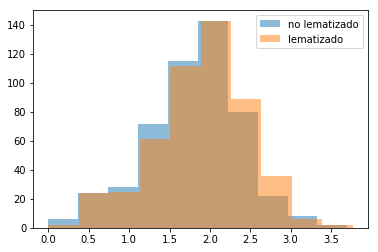

In [76]:
plt.hist(concre_media,alpha = 0.5,label="no lematizado")
plt.hist(concre_media_l,alpha = 0.5,label="lematizado")
plt.legend(loc='upper right')
## hay un toque de diferencia, pero tampoco la pavada. 
## el lematizador despues lo trato de mejorar con pos tagging 

In [106]:
## POR AHORA ME QUEDO SOLAMENTE CON LA MEDIA SIN LEMATIZAR. DESPUES LO SIGO LABURANDO 

In [77]:
concre_media = trainset_texto.apply(lambda x: np.mean([conc_src(ele) for ele in x.split()]))

In [ ]:
## en otro feature cuento la cantidad de palabras con una concreción baja (palabras abstractas)
## pongo un umbral de 2.5 para decir que es baja o alta (el maximo es 5)

In [78]:
def es_abstracta(ele):
    if ele in conc_rating.Word.values:
        score = conc_rating.loc[conc_rating['Word'] == ele,"Conc.M"]
        return float(score) < 2.5
    else:
        return False
    
cant_abstractas = trainset_texto.apply(lambda x: sum([es_abstracta(ele) for ele in x.split()]))

In [79]:
df_comp_train = pd.concat([coma,puntos,parentesis,word_count,letras,charbyword,concre_media, cant_abstractas ],axis=1)
df_comp_train.columns = ["coma","puntos","parentesis","word_count","letras","charbyword","concre_media","cant_abstractas"]

In [60]:
# ACÁ TE AHORRO TIEMPO
df_comp_train = pd.read_csv("df_comp_train.csv",index_col=0)

In [34]:
### en el proximo dejo armado dos modelitos para ir probando.Pero faltan todavia un par de features:
## unas metricas que tengo anotadas y el lexiconde imaginabilidad

In [80]:
silabas = trainset_texto.apply(txt.syllable_count)
flesch= trainset_texto.apply(txt.flesch_reading_ease)
smog = trainset_texto.apply(txt.smog_index)
dale_chal = trainset_texto.apply(txt.dale_chall_readability_score)
ari = trainset_texto.apply(txt.automated_readability_index)

df_comp_train = pd.concat([df_comp_train,silabas,flesch,smog,dale_chal,ari],axis=1)

In [81]:
df_comp_train.columns = ["coma","puntos","parentesis","word_count","letras","charbyword","concre_media","cant_abstractas","silabas","flesch","smog","dale_chal","ari"]

In [82]:
### indice de imaginabilidad
imag_rating= pd.read_csv("DAL_cleaned.txt",sep='\s+',header=None)
imag_rating.columns = ['Word',"p1","p2","p3"]
imag_rating.head(1)

,Word,p1,p2,p3
0,a,2.0,1.3846,1.0


In [38]:
## agrego puntaje de imaginabilidad

In [83]:
def imag_src(ele):
    if ele in imag_rating.Word.values:
        ele = ele.lower()
        p3 = imag_rating.loc[imag_rating['Word'] == ele,"p3"]
        return p3.iloc[0]
    else:
        return float("nan")

### toma el promedio de la imaginabilidad de las palabras
imag_scores = trainset_texto.apply(lambda x: np.nanmean([imag_src(ele) for ele in x.split()]))
imag_scores.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


6793    2.100000
1396    1.266667
5220    1.666667
4894    1.975000
4520    1.511111
4002    1.766667
3108    1.800000
322     1.400000
5779    1.387500
2541    1.340000
Name: text, dtype: float64

In [84]:
def es_imaginable(ele):
    if ele in imag_rating.Word.values:
        score = imag_rating.loc[imag_rating['Word'] == ele,"p3"]
        return float(score) < 1.5
    else:
        return False
    
cant_imaginables =trainset_texto.apply(lambda x: sum([es_imaginable(ele) for ele in x.split()]))


In [85]:
df_comp_train = pd.concat([df_comp_train, imag_scores.rename("imag_score"),cant_imaginables.rename("cant_imaginables")],axis=1)
df_comp_train.head(10)

,coma,puntos,parentesis,word_count,letras,charbyword,concre_media,cant_abstractas,silabas,flesch,smog,dale_chal,ari,imag_score,cant_imaginables
6793,0,1,0,6,25,4.166667,1.365000,1,7,99.23,0.0,0.30,2.0,2.100000,1
1396,0,0,0,4,15,3.750000,2.315000,3,6,75.88,0.0,0.20,-1.9,1.266667,3
5220,0,0,0,4,17,4.250000,1.952500,2,6,75.88,0.0,7.78,0.6,1.666667,2
4894,0,1,0,11,52,4.727273,2.280909,2,18,60.31,0.0,9.92,6.8,1.975000,2
4520,0,1,0,13,46,3.538462,2.619231,4,14,100.58,0.0,5.50,2.1,1.511111,6
4002,0,0,0,8,34,4.250000,2.305000,2,11,80.28,0.0,7.98,2.6,1.766667,4
3108,0,0,0,4,19,4.750000,1.992500,2,6,75.88,0.0,0.20,2.9,1.800000,2
322,0,1,0,7,36,5.142857,1.252857,3,11,64.37,0.0,10.75,7.0,1.400000,3
5779,0,1,0,20,95,4.750000,2.025000,11,28,68.10,0.0,6.21,11.2,1.387500,12
2541,1,1,0,14,61,4.357143,1.613571,7,18,82.65,0.0,7.71,6.8,1.340000,8


In [86]:
df_comp_train.imag_score.loc[df_comp_train.imag_score.isna()] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [87]:
df_comp_train_2 = df_comp_train.apply(lambda x: np.where(x<0,x**2,x))

In [185]:
#mod = linear_model.LogisticRegression()
mod=  MultinomialNB()
# Parametros a variar 
#parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_mod = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod.fit(df_comp_train_2, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod.best_estimator_
mod_score =grid_search_mod.cv_results_["mean_test_score"].max()
#print ("C:",best_clf_mod.C )
print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",grid_search_mod.cv_results_["mean_test_score"].max())

MNB_score =grid_search_mod.cv_results_["mean_test_score"].max()


alpha: 0.001
fscore_cv= 0.4979468118075564


In [89]:
filename = 'nb_complejidad.sav'
pickle.dump(grid_search_mod, open(filename, 'wb'))

In [77]:
df_comp_train.loc[:,'clase'] = trainset_clase.values

In [78]:
medias = df_comp_train.groupby('clase').agg('mean')
medias

,coma,puntos,parentesis,word_count,letras,charbyword,concre_media,cant_abstractas,silabas,flesch,smog,dale_chal,ari,imag_score,cant_imaginables
clase,,,,,,,,,,,,,,,
0,0.104067,0.841707,0.000797,8.294258,35.270734,4.233908,1.820690,3.047448,11.253589,83.212963,0.009928,6.281455,3.294099,1.571211,3.349282
1,0.102830,0.846154,0.002790,7.953766,34.047429,4.272839,1.781949,2.976883,10.907134,82.227923,0.015385,6.509932,3.329016,1.577310,3.161419


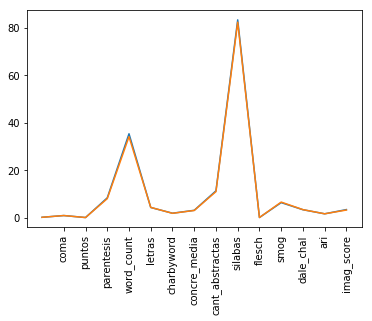

In [79]:
## los perfiles claramente superpuestos
my_xticks = medias.columns
plt.xticks(range(1,15), my_xticks,rotation=90)

plt.plot(range(0,15),medias.iloc[0])
plt.plot(range(0,15),medias.iloc[1])

In [ ]:
# bueno, en este dataset la hipotesis no se cumple.
#Probé métricas que en la literatura funcionan (con diseños que no son de produccion libre)
#acá no marchan, claramente.

In [80]:
df_comp_train = df_comp_train.drop("clase",axis=1).copy()

In [81]:
df_comp_train.columns

Index(['coma', 'puntos', 'parentesis', 'word_count', 'letras', 'charbyword',
       'concre_media', 'cant_abstractas', 'silabas', 'flesch', 'smog',
       'dale_chal', 'ari', 'imag_score', 'cant_imaginables'],
      dtype='object')

TypeError: '>' not supported between instances of 'list' and 'GridSearchCV'

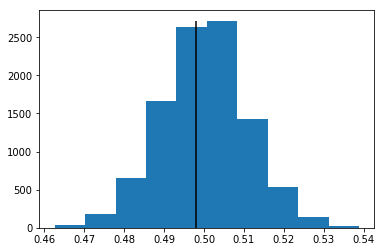

In [186]:
histograma = plt.hist(f_measure_random)
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>grid_search_mod).sum()/len(f_measure_random)))

In [90]:
from sklearn import linear_model


In [ ]:
### HASTA ACA CON EL DE COMPLEJIDAD. SE PUEDE REPETIR EL MISMO CON OTRA HIPOTESIS. O BUSCANDO OTRAS FEATURES

In [ ]:
## por ejemplo

tiene_I =trainset_texto.apply(lambda x: len(re.findall(r"\bI\b",x)))

In [ ]:
### HASTA ACA CON EL DE COMPLEJIDAD. SE PUEDE REPETIR EL MISMO CON OTRA HIPOTESIS. O BUSCANDO OTRAS FEATURES

In [ ]:
## por ejemplo

tiene_I =trainset_texto.apply(lambda x: len(re.findall(r"\bI\b",x)))

In [ ]:
#### pos tagging

In [34]:
pru= trainset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

trainset_texto_pos = pd.Series(columna)


In [35]:
pru= testset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

testset_texto_pos = pd.Series(columna)


In [36]:
trainset_texto_pos.head(10)

0    i_N will_M stay_V up_R till_R 12_C am_V tomorr...
1                            we_P sleep_V in_I night_N
2    i_N was_V in_I hurry_N yesterday_N and_C inste...
3                     i_N am_V in_I my_P forties_N ._.
4    there_E is_V no_D evidence_N that_I america_N ...
5         a_D blue_J whale_N only_R eats_V squid_N ._.
6                      kodak_N has_V gone_V bankrupt_J
7    i_N was_V lying_V when_W i_N said_V i_J love_V...
8    my_P friend_N can_M smell_V with_I the_D help_...
9                             orange_N is_V blue_J ._.
dtype: object

In [37]:
count_vect = CountVectorizer(tokenizer=word_tokenize, min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto_pos)
testset_texto_token = count_vect.transform(testset_texto_pos)

In [326]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()

alpha: 10
fscore_cv= 0.5942553842888033


In [100]:
filename = 'nb_postag.sav'
pickle.dump(grid_search_MNB, open(filename, 'wb'))

In [101]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_mod = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod.best_estimator_
mod_score =grid_search_mod.cv_results_["mean_test_score"].max()
print ("C:",best_clf_mod.C )
#print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",grid_search_mod.cv_results_["mean_test_score"].max())



C: 0.1
fscore_cv= 0.6040908400848816


In [102]:
filename = 'logistica_postag.sav'
pickle.dump(grid_search_mod, open(filename, 'wb'))

In [ ]:
## empath

In [103]:
lexicon = Empath()
pru = trainset_texto

nuevo_df = []

for frase in pru:
    vectorcito = lexicon.analyze(frase).values()
    nuevo_df.append(list(vectorcito))
    


In [104]:
nuevo_df = pd.DataFrame(nuevo_df)

In [206]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_mod = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod.fit(nuevo_df, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod.best_estimator_
mod_score =grid_search_mod.cv_results_["mean_test_score"].max()
print ("C:",best_clf_mod.C )
#print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",grid_search_mod.cv_results_["mean_test_score"].max())


C: 0.1
fscore_cv= 0.5199119288207736


Text(0.5,1,'p-val=0.0359')

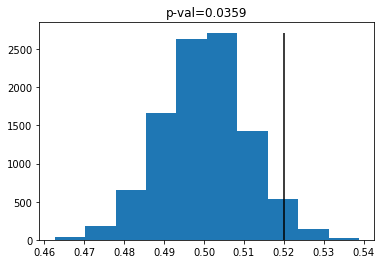

In [207]:
score = grid_search_mod.cv_results_["mean_test_score"].max()
histograma = plt.hist(f_measure_random)
plt.vlines(score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>score).sum()/len(f_measure_random)))

In [162]:
filename = 'nb_empath.sav'
pickle.dump(grid_search_mod, open(filename, 'wb'))

4013

In [38]:
autoref_i    = trainset_texto.apply(lambda x: len(re.findall(r"\bi\b",x.lower())))
autoref_my   = trainset_texto.apply(lambda x: len(re.findall(r"\bmy\b",x.lower())))
autoref_mine = trainset_texto.apply(lambda x: len(re.findall(r"\bmine\b",x.lower())))
autoref_me   = trainset_texto.apply(lambda x: len(re.findall(r"\bme\b",x.lower())))
autoref_mys  = trainset_texto.apply(lambda x: len(re.findall(r"\bmyself\b",x.lower())))

In [24]:
warriner = pd.read_csv("warriner.csv",index_col=0)

In [25]:
def warriner_src(palabrita):
    letra = nltk.pos_tag([palabrita])[0][1][0].lower()
    if letra in ["a","v","n","r","s",]:
        palabrita = WordNetLemmatizer().lemmatize(palabrita,pos=letra)
    else: 
        palabrita = WordNetLemmatizer().lemmatize(palabrita)
    if palabrita in warriner.Word.values:
        ans = warriner.loc[warriner.Word == palabrita,]
        return list(warriner.loc[warriner.Word == palabrita,['V.Mean.Sum','A.Mean.Sum','D.Mean.Sum']].iloc[0])
    else:
        return [float("nan"),float("nan"),float("nan")]



In [41]:
valencia = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[0] for palabra in x.split()]))
arousal = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[1] for palabra in x.split()]))
dominancia = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[2] for palabra in x.split()]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
df_otros = pd.concat({"val":valencia,"aro":arousal,"dom":dominancia,"auto_mys":autoref_mys,"auto_me":autoref_me,"auto_i":autoref_i,"auto_mine":autoref_mine,"auto_my":autoref_my},axis=1)

In [27]:
neg_words = pd.read_csv("negative-words.txt",comment=";",encoding="latin1")
neg_words.columns = ["Word"]
pos_words = pd.read_csv("positive-words.txt",comment=";",encoding="latin1")
pos_words.columns = ["Word"]

In [28]:
positivas = trainset_texto.apply(lambda x :sum([palabra in pos_words.Word.values for palabra in x.split()]))
negativas = trainset_texto.apply(lambda x :sum([palabra in neg_words.Word.values for palabra in x.split()]))

In [29]:
df_otros = pd.concat([df_otros,positivas.rename("pos"),negativas.rename("neg")],axis=1)

NameError: name 'df_otros' is not defined

In [ ]:
df_otros = pd.read_csv("otros.csv",index_col=0)

In [ ]:
df_otros= df_otros.assign(emp = emp.values)

In [47]:
clase_otros = trainset_clase.drop(df_otros[df_otros.isna().any(1)].index)
df_otros = df_otros.dropna()

In [320]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
# define un grid search a realizar 
grid_search_mod = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod.fit(df_otros, clase_otros)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod.best_estimator_
mod_score =grid_search_mod.cv_results_["mean_test_score"].max()
print ("C:",best_clf_mod.C )
#print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",grid_search_mod.cv_results_["mean_test_score"].max())

MNB_score =grid_search_mod.cv_results_["mean_test_score"].max()


alpha: 10
fscore_cv= 0.5323936829320618


In [155]:
filename = 'nb_otros.sav'
pickle.dump(grid_search_mod, open(filename, 'wb'))

Text(0.5,1,'p-val=0.0')

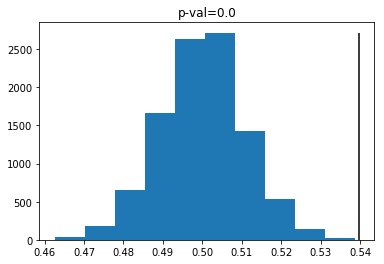

In [211]:
score = grid_search_mod.cv_results_["mean_test_score"].max()
histograma = plt.hist(f_measure_random)
plt.vlines(score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>score).sum()/len(f_measure_random)))

# Acá empiezo los ensambles

### Cargo los modelos que performaron por arriba del azar (con p <0.05)

In [147]:
nb_lemmatizado_sololetras = pickle.load(open("nb_lemmatizado_sololetras.sav","rb"))
randomforest_lemmatizado_sololetras = pickle.load(open("randomforest_lemmatizado_sololetras.sav","rb"))
logistica_otros = pickle.load(open("logistica_otros.sav","rb"))
logistica_postag = pickle.load(open("logistica_postag.sav","rb"))
nb_otros = pickle.load(open("nb_otros.sav","rb"))
nb_postag =  pickle.load(open("nb_postag.sav","rb"))


### Acá estan los devsets preparados

In [148]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=LemmaTokenizer(), min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit(trainset_texto)
devset_basico_lemma = count_vect.transform(devset_texto)

In [154]:
pru= devset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

testset_texto_pos = pd.Series(columna)

pru= trainset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

trainset_texto_pos = pd.Series(columna)



count_vect = CountVectorizer(tokenizer=word_tokenize, min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto_pos)
devset_postag = count_vect.transform(devset_texto)

### acá armo el devset para "otros" que tendria que haberlo metido en una funcion pero soy un boludo

In [140]:
autoref_i    = devset_texto.apply(lambda x: len(re.findall(r"\bi\b",x.lower())))
autoref_my   = devset_texto.apply(lambda x: len(re.findall(r"\bmy\b",x.lower())))
autoref_mine = devset_texto.apply(lambda x: len(re.findall(r"\bmine\b",x.lower())))
autoref_me   = devset_texto.apply(lambda x: len(re.findall(r"\bme\b",x.lower())))
autoref_mys  = devset_texto.apply(lambda x: len(re.findall(r"\bmyself\b",x.lower())))
valencia     = devset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[0] for palabra in x.split()]))
arousal      = devset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[1] for palabra in x.split()]))
dominancia   = devset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[2] for palabra in x.split()]))
devset_otros = pd.concat({"val":valencia,"aro":arousal,"dom":dominancia,"auto_mys":autoref_mys,"auto_me":autoref_me,"auto_i":autoref_i,"auto_mine":autoref_mine,"auto_my":autoref_my},axis=1)
positivas = devset_texto.apply(lambda x :sum([palabra in pos_words.Word.values for palabra in x.split()]))
negativas = devset_texto.apply(lambda x :sum([palabra in neg_words.Word.values for palabra in x.split()]))
devset_otros = pd.concat([devset_otros,positivas.rename("pos"),negativas.rename("neg")],axis=1).fillna(0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


### Acá los predicts

In [155]:
nb_lemmatizado_sololetras_pred = nb_lemmatizado_sololetras.predict(devset_basico_lemma)
randomforest_lemmatizado_sololetras_pred = randomforest_lemmatizado_sololetras.predict(devset_basico_lemma)
logistica_otros_pred = logistica_otros.predict(devset_otros)
nb_otros_pred = nb_otros.predict(devset_otros)
logistica_postag_pred = logistica_postag.predict(devset_postag)
nb_postag_pred = nb_postag.predict(devset_postag)


In [156]:
predicciones = pd.concat({"nb_base":pd.Series(nb_lemmatizado_sololetras_pred),"rf_base":pd.Series(randomforest_lemmatizado_sololetras_pred),"log_otros":pd.Series(logistica_otros_pred),"nb_otros":pd.Series(nb_otros_pred),"log_post":pd.Series(logistica_postag_pred),"nb_post":pd.Series(nb_postag_pred)},axis=1)

In [157]:
predicciones.head()

,log_otros,log_post,nb_base,nb_otros,nb_post,rf_base
0,1,1,0,1,1,0
1,0,1,0,0,1,0
2,1,1,1,0,1,1
3,1,1,1,0,1,0
4,0,1,1,0,1,0


In [158]:
predicciones.to_csv("predicciones_devset.csv")

In [309]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [313]:
Z = linkage(np.transpose(predicciones), 'ward')

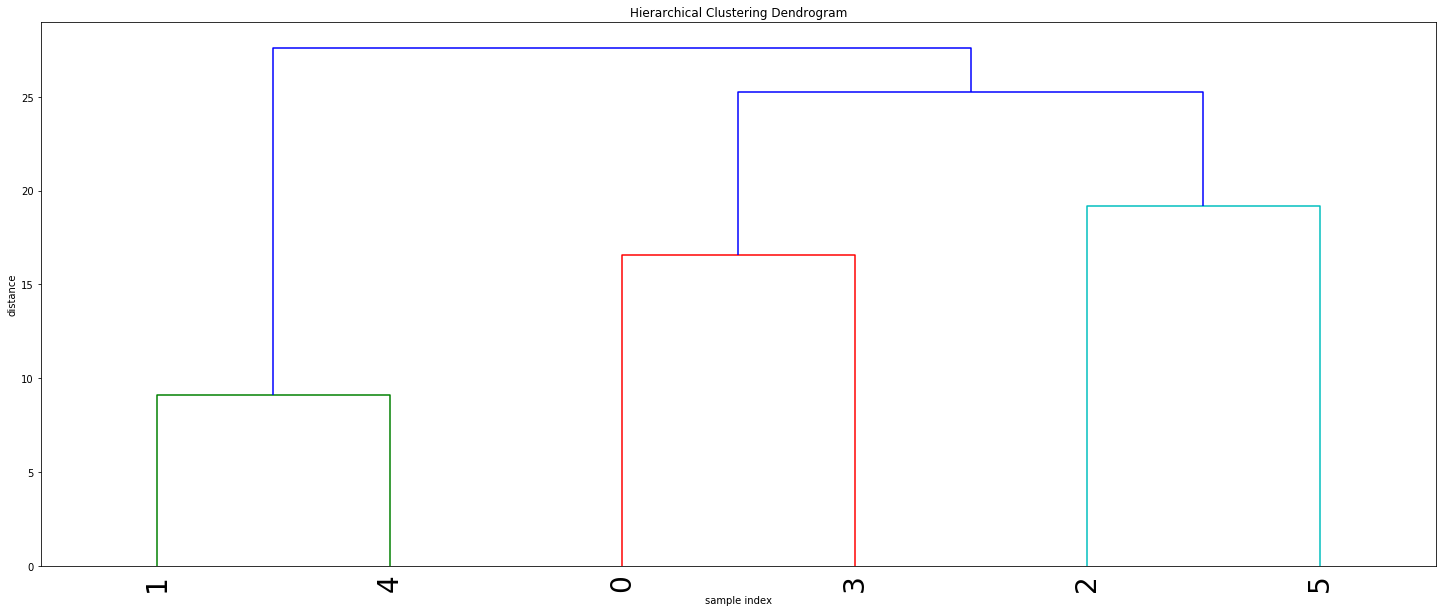

In [318]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=28.,  # font size for the x axis labels
)
plt.show()


### Basicamente me está diciendo que tome uno de cada dataset

#### Tomo rf base,  logistica otros, logistica de postagging (los que mejor andaron de cada dataset) 

In [430]:
pred_f = predicciones.iloc[:,[0,1,5]]

In [431]:
pred_f = pred_f.assign(final = pred_f.apply(sum,1) > 1)

In [432]:
votacion = pred_f.final.apply(int)

In [434]:
f1_score(votacion,devset_clase)

0.6269349845201239

#### Usando todos los modelos y no solo los de baja correlacion

In [435]:
pred_f = pred_f.assign(final = predicciones.apply(sum,1) > 1)
votacion = pred_f.final.apply(int)
f1_score(votacion,devset_clase)

0.6653279785809906

NameError: name 'prediccion' is not defined

## Y ahora sobre testset

### Uso todo el trainset


In [8]:
trainset_texto, testset_texto, trainset_clase, testset_clase =  train_test_split(df.text,df.clase,stratify=df.clase, test_size=0.3, random_state = 123)

In [12]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=LemmaTokenizer(), min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto)
testset_texto_token = count_vect.transform(testset_texto)

In [13]:
pru= trainset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

trainset_texto_pos = pd.Series(columna)

count_vect = CountVectorizer(tokenizer=word_tokenize, min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token_pos = count_vect.fit_transform(trainset_texto_pos)

In [14]:
pru= testset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

testset_texto_pos = pd.Series(columna)

count_vect = CountVectorizer(tokenizer=word_tokenize, min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token_pos = count_vect.fit_transform(trainset_texto_pos)
testset_postag = count_vect.transform(testset_texto_pos)


In [30]:
autoref_i    = trainset_texto.apply(lambda x: len(re.findall(r"\bi\b",x.lower())))
autoref_my   = trainset_texto.apply(lambda x: len(re.findall(r"\bmy\b",x.lower())))
autoref_mine = trainset_texto.apply(lambda x: len(re.findall(r"\bmine\b",x.lower())))
autoref_me   = trainset_texto.apply(lambda x: len(re.findall(r"\bme\b",x.lower())))
autoref_mys  = trainset_texto.apply(lambda x: len(re.findall(r"\bmyself\b",x.lower())))
valencia     = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[0] for palabra in x.split()]))
arousal      = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[1] for palabra in x.split()]))
dominancia   = trainset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[2] for palabra in x.split()]))
trainset_otros = pd.concat({"val":valencia,"aro":arousal,"dom":dominancia,"auto_mys":autoref_mys,"auto_me":autoref_me,"auto_i":autoref_i,"auto_mine":autoref_mine,"auto_my":autoref_my},axis=1)
positivas = trainset_texto.apply(lambda x :sum([palabra in pos_words.Word.values for palabra in x.split()]))
negativas = trainset_texto.apply(lambda x :sum([palabra in neg_words.Word.values for palabra in x.split()]))
trainset_otros = pd.concat([trainset_otros,positivas.rename("pos"),negativas.rename("neg")],axis=1).fillna(0)


c:\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
c:\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [31]:
autoref_i    = testset_texto.apply(lambda x: len(re.findall(r"\bi\b",x.lower())))
autoref_my   = testset_texto.apply(lambda x: len(re.findall(r"\bmy\b",x.lower())))
autoref_mine = testset_texto.apply(lambda x: len(re.findall(r"\bmine\b",x.lower())))
autoref_me   = testset_texto.apply(lambda x: len(re.findall(r"\bme\b",x.lower())))
autoref_mys  = testset_texto.apply(lambda x: len(re.findall(r"\bmyself\b",x.lower())))
valencia     = testset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[0] for palabra in x.split()]))
arousal      = testset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[1] for palabra in x.split()]))
dominancia   = testset_texto.apply(lambda x : np.nanmean([warriner_src(palabra)[2] for palabra in x.split()]))
testset_otros = pd.concat({"val":valencia,"aro":arousal,"dom":dominancia,"auto_mys":autoref_mys,"auto_me":autoref_me,"auto_i":autoref_i,"auto_mine":autoref_mine,"auto_my":autoref_my},axis=1)


c:\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
c:\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
c:\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [32]:
positivas = testset_texto.apply(lambda x :sum([palabra in pos_words.Word.values for palabra in x.split()]))
negativas = testset_texto.apply(lambda x :sum([palabra in neg_words.Word.values for palabra in x.split()]))
testset_otros = pd.concat([testset_otros,positivas.rename("pos"),negativas.rename("neg")],axis=1).fillna(0)

In [33]:
testset_otros.shape

(2151, 10)

### los modelos

In [16]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
modelo1 = grid_search_MNB.predict(testset_texto_token)


alpha: 3
fscore_cv= 0.5523782385810833


In [17]:
clf_RF = RandomForestClassifier(class_weight="balanced",random_state=123)
# Parametros a variar 
parameters = {'n_estimators':[1200],'max_features': [10],"max_depth":[5] }
# define un grid search a realizar 
grid_search_RF = GridSearchCV(clf_RF, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_RF.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_RF = grid_search_RF.best_estimator_
print ("n_estimators:",best_clf_RF.n_estimators,"; max_features:",best_clf_RF.max_features,"; max_depth:",best_clf_RF.max_depth )
print("fscore_cv=",grid_search_RF.cv_results_["mean_test_score"].max())
modelo2 = grid_search_RF.predict(testset_texto_token)

n_estimators: 1200 ; max_features: 10 ; max_depth: 5
fscore_cv= 0.5561487319572994


In [18]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB_postag = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB_postag.fit(trainset_texto_token_pos, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
modelo3 = grid_search_MNB_postag.predict(testset_postag)

alpha: 3
fscore_cv= 0.5523782385810833


In [19]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_mod_postag = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod_postag.fit(trainset_texto_token_pos, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod_postag.best_estimator_
mod_score =grid_search_mod_postag.cv_results_["mean_test_score"].max()
print ("C:",best_clf_mod.C )
#print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",grid_search_mod_postag.cv_results_["mean_test_score"].max())
modelo4 = grid_search_mod_postag.predict(testset_postag)


C: 0.1
fscore_cv= 0.5998130944215614


In [34]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
log_grid_search_mod_otros = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
log_grid_search_mod_otros.fit(trainset_otros, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = log_grid_search_mod_otros.best_estimator_
mod_score =log_grid_search_mod_otros.cv_results_["mean_test_score"].max()
print ("C:",best_clf_mod.C )
#print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",log_grid_search_mod_otros.cv_results_["mean_test_score"].max())
modelo5 = log_grid_search_mod_otros.predict(testset_otros)



C: 0.1
fscore_cv= 0.5445113515015527


In [35]:
mod=  MultinomialNB()
# Parametros a variar 
#parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
nb_grid_search_mod_otros = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
nb_grid_search_mod_otros.fit(trainset_otros, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = nb_grid_search_mod_otros.best_estimator_
mod_score =nb_grid_search_mod_otros.cv_results_["mean_test_score"].max()
#print ("C:",best_clf_mod.C )
print ("alpha:",best_clf_mod.alpha )
print("fscore_cv=",nb_grid_search_mod_otros.cv_results_["mean_test_score"].max())
modelo6 = nb_grid_search_mod_otros.predict(testset_otros)

alpha: 3
fscore_cv= 0.5300497572363805


In [ ]:
## sacar a csv el prediccion de devset y el de testset

In [56]:
modelo7 = pd.read_csv('cnn_fasttext_submission.csv')['prediccion']

In [46]:
modelo8 = pd.read_csv('lsa_knn_submission.csv')['prediccion']

In [80]:
prediccion_test = pd.concat([pd.Series(modelo1),pd.Series(modelo2),pd.Series(modelo3),pd.Series(modelo4),pd.Series(modelo5),pd.Series(modelo6), modelo7, modelo8],axis=1)

In [81]:
prediccion_test.head()

,0,1,2,3,4,5,prediccion,prediccion
0,1,1,1,1,0,1,1,0
1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,1
3,1,1,1,1,1,1,1,1
4,1,0,1,1,1,1,1,1


In [37]:
prediccion_test.to_csv("predicciones_testset.csv")

In [82]:
prediccion_test = prediccion_test.assign(final = prediccion_test.apply(sum,1) > 1)
votacion = prediccion_test.final.apply(int)
f1_score(votacion,testset_clase)

0.6659807956104253